In [95]:
import numpy as np
import matplotlib.pyplot as plt
#import odeint
from scipy.integrate import odeint
# import brentq
from scipy.optimize import brentq
from solveTmu import blackness
# import solve_ivp
from scipy.integrate import solve_ivp
# import interp1d from scipy
from scipy.interpolate import interp1d


def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    u=np.linspace(ui,uf,1000)
    u_backward=np.linspace(uf,ui,1000)
    "Matching Fang paper"
    v4=4.2
    v3= -22.6/(6*np.sqrt(2))

    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=8*v4/3


    zh,q = blackness(T,mu)
    Q=q*zh**3

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))


    "IR boundary condition"
    chi0=d0+d1*(1-uf)
    chip0=d1
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    #create an interpolating function for chi
    chi_interp=interp1d(u,chi)

    mq=chip[0]/(zeta*zh)
    u_intermediate=0.05
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta

    return mq,sigma,chi,chip,u

mq is  0.014068180483615505
sigma is  1729240.6076948764
sl is  1200.2871090086826


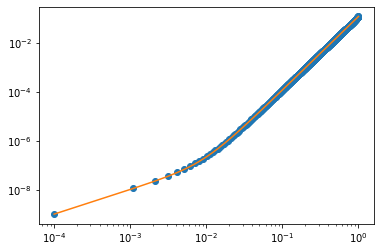

In [100]:
lambda1=7
T=120
mu=0
ui=1e-4
uf=1-ui
d0=0.117
zeta=np.sqrt(3)/(2*np.pi)
mq,sigma,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
print("mq is ", mq)
print("sigma is ", sigma)
print("sl is ", (sigma*1000)**(1/3 ))
plt.loglog(u,chi,'o')
plt.loglog(u,u*zeta*zh*mq+sigma/zeta*(zh*u)**3)
plt.show()

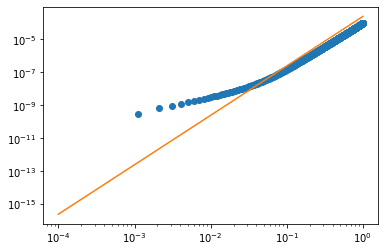

In [91]:
plt.loglog(u,chi-u*zeta*zh*mq,'o')
plt.loglog(u,sigma/zeta*(zh*u)**3)


0.1174258438389971
9.999999996595153e-05


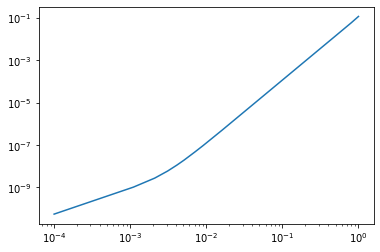

In [46]:
#Use brentq to find the value of d0 that gives mq=mq_input
mq_input=1e-4
def find_d0(d0):
    mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
    return mq-mq_input

d0=brentq(find_d0,.0001,0.3)
print(d0)

mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
print(mq)
plt.loglog(u,chi)
plt.show()


In [102]:
# use a root-finding method that only requires one initial guess to find the value of d0 that gives mq_input
from scipy.optimize import root_scalar
mq_input=1e-4
T=100
def find_d0(d0):
    mq,sigma,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
    return mq-mq_input

sol=root_scalar(find_d0,x0=.1,x1=.3)
d0=sol.root
print('d0 is ', d0)

mq,sigma, chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
print('quark mass is ', mq)
plt.loglog(u,chi)
plt.loglog(u,u*mq*zeta)
plt.show()

ValueError: too many values to unpack (expected 4)

quark mass is  11.405452018712493


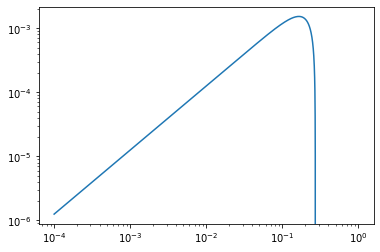

In [55]:
T=80
d0=-.4
mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
print('quark mass is ', mq)
plt.loglog(u,chi)
plt.show()